<a href="https://colab.research.google.com/github/kristina-pal/BD4_Assignment/blob/main/3461226_BD4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center><h1>**Enhancing the Business Efficiency of V.Ger Travel Through Data Science**</h1></center>

# **1. Introduction**
The travel conglomerate was analysed, and four key use cases were identified as the most relevant for implementing Data Science methods to improve business efficiency. Among them, forecasting hotel booking demand was selected for detailed investigation, as it plays a crucial role in effective planning and decision-making in the travel industry.

To support this use case, a synthetic time series was generated to replicate realistic booking patterns typically observed in hotel operations. Time Series Forecasting techniques were then applied to predict future hotel booking demand.


###</br> **Four Key Use Cases for the Travel Industry:**

 **1. Forecasting Demand for hotel, flight, and car bookings**

Forecasting demand for various services helps allocate staff efficiently, manage hotel occupancy, plan procurement and maintenance and prevent shortages or oversupply. Furthermore, accurate demand prediction forms the foundation of dynamic pricing.

*Time Series modelling can be applied to this case to capture trends, seasonal patterns, and fluctuations in the data, allowing the company to predict future demand.*

</br> **2. Analysing Customer Satisfaction**

Customer satisfaction analysis identifies the factors that influence guests' ratings, such as price, room comfort, reception service, staff responsiveness, and food quality.

This helps businesses:
* improve service where it matters most;
* enhance ratings on platforms like Booking.com and TripAdvisor;
* reduce the number of complaints;
* increase repeat bookings.

*Linear Regression (OLS) can be applied to identify factors that have a significant impact on customer ratings and to quantify the strength and direction of these effects.*

</br> **3. Price Modelling**

Price modelling evaluates how the price per night depends on factors such as seasonality, hotel rating, room type, distance to the beach, and customer reviews. Understanding these relationships allows businesses to optimise pricing strategies and maximise revenue.

*Time Series and OLS Regression can be applied to reveal how price depends on hotel characteristics and external factors.*

</br> **4. Comparing user responses to website designs (A/B Testing)**

A/B testing of website layouts and advertising materials allows companies to compare different page designs, promotional banners, text, call-to-action buttons and hotel search structures.

This method:
* increases website conversion rates;
* boosts sales without raising the advertising budget;
* helps select the most effective design based on data.

*Hypothesis testing (such as t-test or z-test) can be applied to determine whether one design performs significantly better than another.*

#</br> **2. Time Series Forecasting for Hotel Booking Demand**

Demand forecasting is essential in the travel industry, as most operational processes depend on seasonality, long-term trends, and advance planning.

</br>**2.1 Time Series Generation**

To forecast hotel booking demand, a synthetic time series with a trend and seasonality should be generated. The following dataset reflects realistic booking patterns, where demand increases during peak seasons and decreases during off-peak periods. The generated time series will be then modelled using an ARIMA/SARIMA-based forecasting approach to predict future hotel bookings.

In [131]:
# @title
# Time Series generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')

def generate_time_series(n_periods=100, frequency='days', trend_slope=0.3, seasonal_period='monthly', seasonal_amplitude=5, noise_level=0.5):
    # Set frequency based on the input (days, months, or weeks)
    if frequency == 'days':
        freq = 'D'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'months':
        freq = 'M'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'weeks':
        freq = 'W'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    # 1. Create a linear trend: A simple increasing trend from 0 to trend_slope * n_periods
    trend = np.linspace(0, trend_slope * n_periods, n_periods)  # Linear trend

    # 2. Add seasonality based on the chosen period (weekly, monthly, or annual)
    seasonal_component = np.zeros(n_periods)
    if seasonal_period == 'monthly':
        # One full cycle per year (12 months)
        seasonal_frequency = 2 * np.pi / 12  # For monthly frequency
    elif seasonal_period == 'weekly':
        # One full cycle per year (52 weeks)
        seasonal_frequency = 2 * np.pi / 52  # For weekly frequency
    elif seasonal_period == 'annual':
        # One full cycle per year (365 days)
        seasonal_frequency = 2 * np.pi / 365  # For annual frequency
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

    # Smooth seasonal component (sine wave with the defined frequency)
    seasonal_component = seasonal_amplitude * np.sin(np.linspace(0, seasonal_frequency * n_periods, n_periods))

    # 3. Add minimal noise to the time series to make the residuals more realistic
    noise = np.random.normal(0, noise_level, n_periods)

    # 4. Combine the trend and seasonality
    time_series = trend + seasonal_component + noise

    # Prepare data for CSV output
    data = {'Time': time_index[:len(time_series)], 'Value': time_series}
    t_s = pd.DataFrame(data)

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(t_s['Time'], t_s['Value'], label='Generated Time Series',  color='blue')
    plt.title('Generated Time Series Data with Trend and Seasonality')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Save to CSV
    t_s.to_csv('/content/drive/My Drive/t_s.csv', index=False)

    return t_s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-2356864722.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)


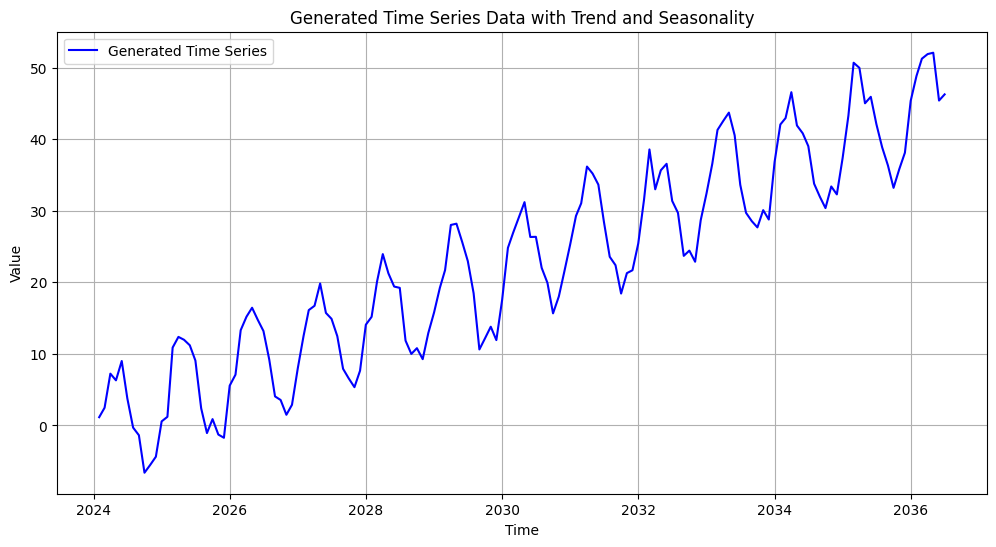

In [117]:
# @title
# Generated Time Series
t_s = generate_time_series(n_periods=150, frequency='months', trend_slope=0.3, seasonal_period='monthly', seasonal_amplitude=8, noise_level=1.5)

The generated trend and seasonality alignment chart shows:
* a clear upward movement (increasing trend);
* regular cyclic up-and-down patterns (seasonality);
* small irregular fluctuations (noise).

This indicates that the time series is predictable and follows an additive structure.

**2.2 Decomposition**

The next step is to decompose the time series into its components to better understanding of the underlying trend, seasonal patterns, and residual noise, which will help determine whether the series is suitable for ARIMA/SARIMA modelling.

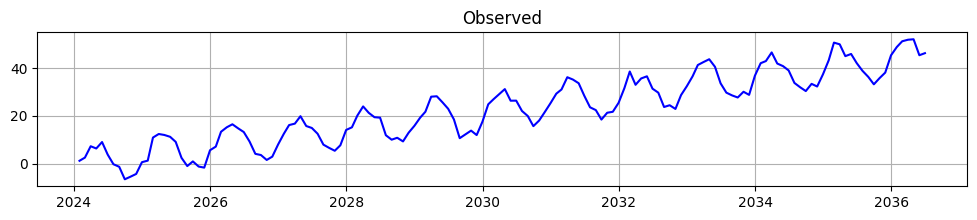

In [118]:
# @title
# Decompose the Time Series

def decompose_time_series(t_s, frequency='M'):

    t_s = t_s.copy()
    t_s['Time'] = pd.to_datetime(t_s['Time'])
    t_s = t_s.set_index('Time')

    decomposition = seasonal_decompose(t_s['Value'], model='additive', period=12)

    return decomposition

# Separate plots to describe each of them

def plot_decomposition_separately(decomposition):

    # Observed Plot
    plt.figure(figsize=(12, 2))
    plt.plot(decomposition.observed, color='blue')
    plt.title('Observed')
    plt.grid(True)
    plt.show()

result = decompose_time_series(t_s, frequency='M')
plot_decomposition_separately(result)

**The Observed plot** represents the original time series used in the decomposition process.

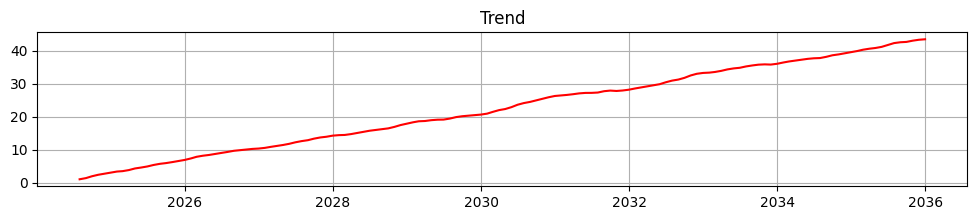

In [119]:
# @title
# Trend Plot

plt.figure(figsize=(12, 2))
plt.plot(result.trend, color='red')
plt.title('Trend')
plt.grid(True)

plt.show()

**The Trend plot** shows that the value of the series increases steadily with each period.

This means:
* bookings (or the value we are modeling) are increasing over time;
* the trend is stable, without sharp jumps;
* the trend is nearly linear, which simplifies ARIMA/SARIMA modeling.

*Overall, this indicates that the number of bookings is rising year after year — possibly due to growing demand, expansion of the hotel network, or general growth in the tourism industry.*

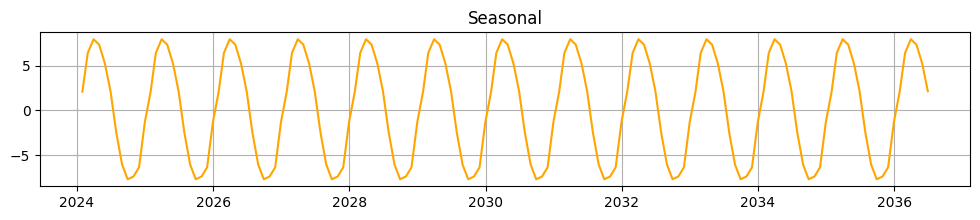

In [120]:
# @title
# Seasonal
plt.figure(figsize=(12, 2))
plt.plot(result.seasonal, color='orange')
plt.title('Seasonal')
plt.grid(True)

plt.show()

**The Seasonal plot** shows:
* clear, repeating cycles of the same shape;
* seasonality is stable in amplitude and frequency;
* peaks are repeated every period (in our case, monthly seasonality).

*That means that in the summer (or certain months), bookings increase, while in the winter, they decline. This is typical for the tourism industry.*

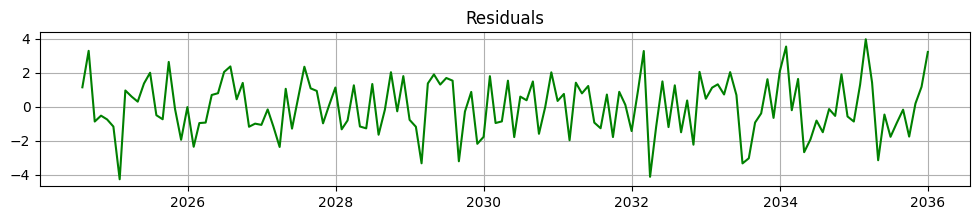

In [121]:
# @title
# Residuals

plt.figure(figsize=(12, 2))
plt.plot(result.resid, color='green')
plt.title('Residuals')
plt.grid(True)

plt.show()

**The Residuals graph** shows that the remaining variation in the series is random and does not exhibit any visible structure.

In the residuals plot: there is no trend; no seasonality; the fluctuations are irregular and roughly uniformly distributed.

This indicates that:
- the trend + seasonality model correctly describes the series;
- there are sufficient data to apply ARIMA/SARIMA;
- the noise component is additive and stationary.

ARIMA/SARIMA models will perform well because the systematic part of the series is explained by deterministic components (trend and seasonality), while the residuals behave like random noise without patterns.

</br> **2.3 Lag Plot**

A lag plot helps to check whether the current value of a time series is related to its past values (lags)— an important requirement for ARIMA/SARIMA modelling.

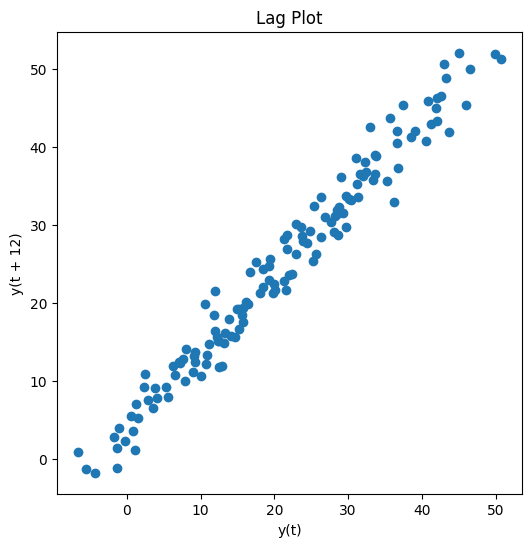

In [122]:
# @title
# Lag Plot

from pandas.plotting import lag_plot

lag_value = 12
plt.figure(figsize=(6, 6))
lag_plot(t_s['Value'], lag = lag_value)
plt.title("Lag Plot")

plt.show()

**The lag plot** with a 12-month lag shows a clear, strong line; and indicates that the value of the time series one year ahead is highly correlated with its value in the same month of the previous year, confirming consistent annual cycles in hotel booking demand.

*This pattern suggests that:*
- the series exhibits strong yearly seasonality;
- observations 12 months apart follow very similar dynamics;
- the series is highly predictable at seasonal intervals;
- the data structure is suitable for SARIMA, which requires seasonal autocorrelation.

**2.4 Autocorrelation Function (ACF) Plot**

The ACF plot shows how a time series is related to its past values.

It helps identify short-term dependencies, the presence of autocorrelation, and seasonal patterns — key elements for selecting appropriate ARIMA/SARIMA model parameters.

<Figure size 1000x600 with 0 Axes>

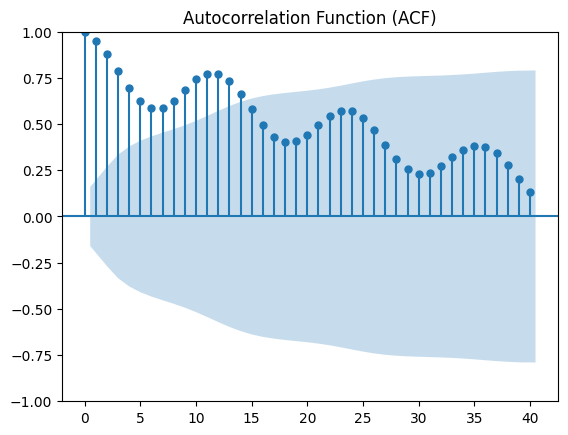

In [123]:
# @title
# ACF Plot

from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(t_s['Value'], lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.show()

**The ACF plot** shows strong positive autocorrelation at the first several lags, indicating that recent values of the series are strongly dependent on previous values. The autocorrelation decreases gradually, which is typical for a time series containing a trend component.

*A clear seasonal pattern is visible: a pronounced peak at lag 12 and 24, and a smaller peak near lag 36.*

These repeated spikes confirm yearly seasonality in the data.

**2.5 Rolling Mean**

The rolling mean smooths out short-term fluctuations and highlights the long-term trend in the data.

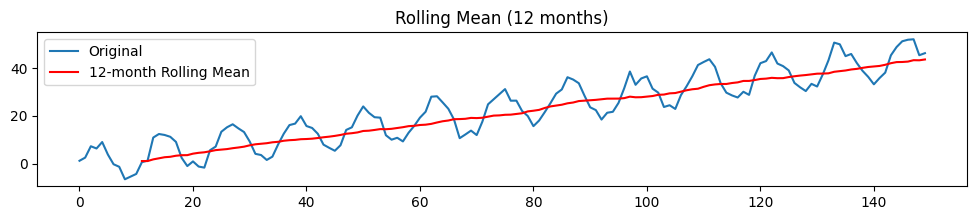

In [124]:
# @title
# Rolling Mean Plot

plt.figure(figsize=(12, 2))
plt.plot(t_s['Value'], label='Original')
plt.plot(t_s['Value'].rolling(window=12).mean(), label='12-month Rolling Mean', color='red')
plt.title("Rolling Mean (12 months)")
plt.legend()
plt.show()

**The red rolling-mean curve** shows a clear upward trajectory, confirming the presence of a strong positive trend in hotel booking demand.

*Overall, the rolling mean confirms that the time series is non-stationary and contains a strong trend component, which justifies the need for differencing when applying ARIMA/SARIMA models.*

**2.6 Stationarity**

Since the generated time series is non-stationary, it must be transformed by applying differencing before fitting forecasting models. Differencing removes the trend and seasonal components, producing a stationary series suitable for ARIMA/SARIMA modelling.

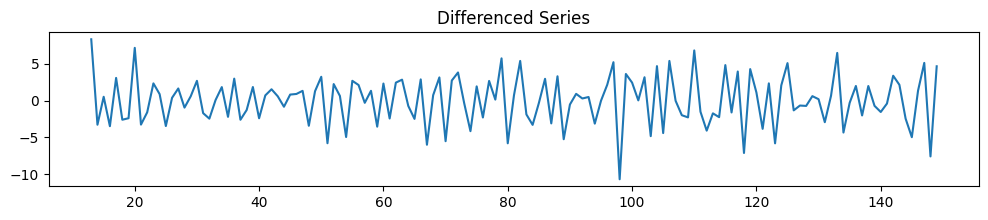

In [125]:
# @title
# Diff Plot

# Differenced series (d=1, D=1, m=12)
diff_total = t_s['Value'].diff(1).diff(12).dropna()

plt.figure(figsize=(12, 2))
plt.plot(diff_total)
plt.title("Differenced Series")
plt.show()

**The Differenced Series plot** represents the result of applying both first non-seasonal differencing and seasonal differencing with a 12-month lag.
This transformation removes the trend and the yearly seasonality, leaving a series that fluctuates around a constant mean around zero.

*These characteristics indicate that the series has become stationary, meaning its statistical properties (mean, variance, autocorrelation) no longer change over time.*

**2.7 Testing for Stationarity**

*a) Augmented Dickey-Fuller (ADF) Test*

The Augmented Dickey-Fuller test evaluates whether a time series contains a unit root.

The null hypothesis (H₀) assumes that the series is non-stationary, meaning its statistical properties change over time.
If the p-value is below the significance level  of 0.05, we reject H₀ and conclude that the series is stationary.

ADF Statistic: -5.058176284268059
p-value: 1.70036172454458e-05
Critical values:
   1%: -3.4846672514209773
   5%: -2.8853397507076006
   10%: -2.5794629869786503


<Figure size 1000x600 with 0 Axes>

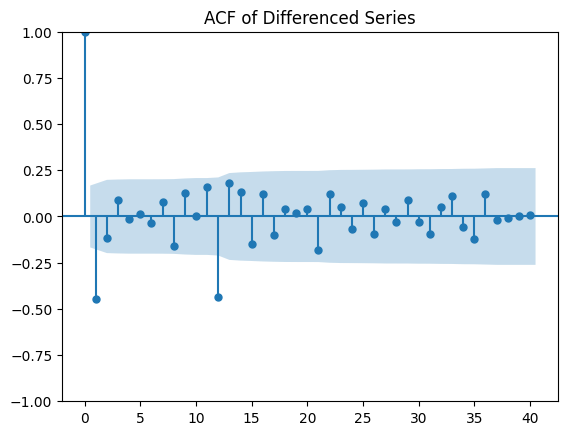

In [126]:
# @title

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# ADF Test
adf_result = adfuller(diff_total)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# ACF Plot
plt.figure(figsize=(10, 6))
plot_acf(diff_total, lags=40)
plt.title("ACF of Differenced Series")
plt.show()

**The p-value** is about **0.00002**, which is far below 0.05. That means that we reject the null hypothesis of non-stationarity and infer that the differenced time series is stationary and suitable for ARIMA/SARIMA modelling.

At the same time, **the ACF plot confirms** that the differenced series behaves like white noise and does not contain any remaining trend or seasonal structure.

*b) Partial Autocorrelation Function (PACF) of Differenced Series*

The PACF plot shows how many lagged values (previous time points) have a direct influence on the current observation. This information is used to determine the appropriate autoregressive order AR(p) for the ARIMA or SARIMA model.

<Figure size 1000x600 with 0 Axes>

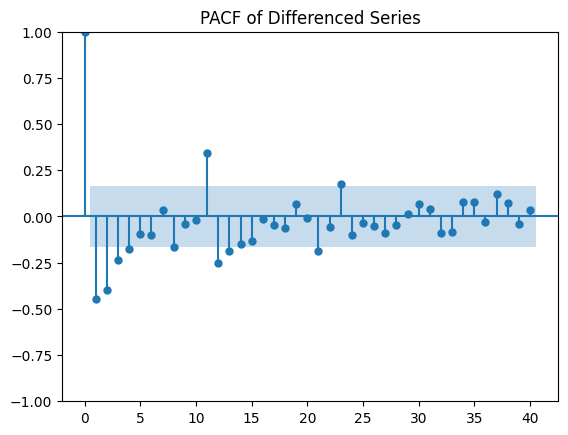

In [127]:
# @title
# PACF plot

from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(diff_total, lags=40, method="ywm")
plt.title("PACF of Differenced Series")
plt.show()

**The PACF plot** displays a dominant spike at lag 1, after which all partial autocorrelations drop to near zero. This indicates an autoregressive structure of order AR(1) and supports choosing p = 1 for ARIMA/SARIMA modelling.

**2.8 Choose AR Order (p) Using Akaike Information Criterion (AIC)**

To determine the optimal autoregressive order p, different ARIMA (p,d,0) models were fitted and compared using the Akaike Information Criterion (AIC). AIC evaluates model quality based on both goodness of fit and model complexity, where lower AIC values indicate a better model.

In [128]:
# @title
# Choosing SARIMA

!pip install pmdarima

from pmdarima import auto_arima

model = auto_arima(t_s['Value'], seasonal=True, m=12, d=1, D=1, trace=True, suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=720.278, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=650.507, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=689.680, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=630.255, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=629.030, Time=0.86 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=627.409, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=626.654, Time=0.26 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=627.317, Time=0.80 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=629.317, Time=1.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=608.038, Time=0.31 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=666.632, Time=0.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=60

**By comparing AIC values** across different AR orders, the model with the lowest AIC value was selected as the most appropriate SARIMA specification:

##**SARIMA(5, 1, 0)(0, 1, 2)[12]** with AIC = 602.066

*This model is the best-performing forecasting model for this time series.*

</br> **2.9 Fitting the SARIMA (5, 1, 0) and Review the Summary**



In [134]:
# @title
import statsmodels.api as sm

# Fit the best SARIMA model
model = sm.tsa.statespace.SARIMAX(t_s['Value'], order=(5,1,0), seasonal_order=(0,1,2,12), enforce_stationarity=False, enforce_invertibility=False)

results = model.fit()
print(results.summary())


                                        SARIMAX Results                                        
Dep. Variable:                                   Value   No. Observations:                  150
Model:             SARIMAX(5, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -238.979
Date:                                 Thu, 04 Dec 2025   AIC                            493.958
Time:                                         13:12:04   BIC                            515.706
Sample:                                              0   HQIC                           502.782
                                                 - 150                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7999      0.089     -9.015      0.000      -0.974      -0

The output shows that the best-fitting model is SARIMA(5, 1, 0)(0, 1, 2)[12], meaning the series was differenced once (d = 1) and includes 5 autoregressive lags (p = 5).

Most AR coefficients (AR(1), AR(2), AR(3), and AR(4)) are statistically significant (p-values < 0.05), indicating that recent observations meaningfully predict the next value.
AR(5) has a p-value of 0.160, meaning it is not statistically significant but does not harm the model.

The Ljung-Box Q-test (p = 0.84) shows no significant autocorrelation remaining in residuals - so the model fits the data reasonably well.

The Jarque-Bera test (p = 0.38) indicates that residuals are normally distributed and the Heteroskedasticity test (p = 0.54) shows variance is stable (no heteroskedasticity)and residuals behave like white noise.

Overall, SARIMA(5, 1, 0)(0, 1, 2)[12] is a strong, well-fitting model that successfully captures both the upward trend and the yearly seasonality in the time series. All diagnostics confirm that the model is appropriate and ready for forecasting.

**2.10 Forecasting and Interpretation**


After fitting the SARIMA(5, 1, 0)(0, 1, 2)[12] model, a 12-step forecast can be generated to predict future hotel booking demand.

The forecast includes:
- point predictions (expected future values);
- 90% and 95% confidence intervals, which reflect uncertainty in the forecast;
- future seasonal fluctuations, consistent with the historical yearly pattern.

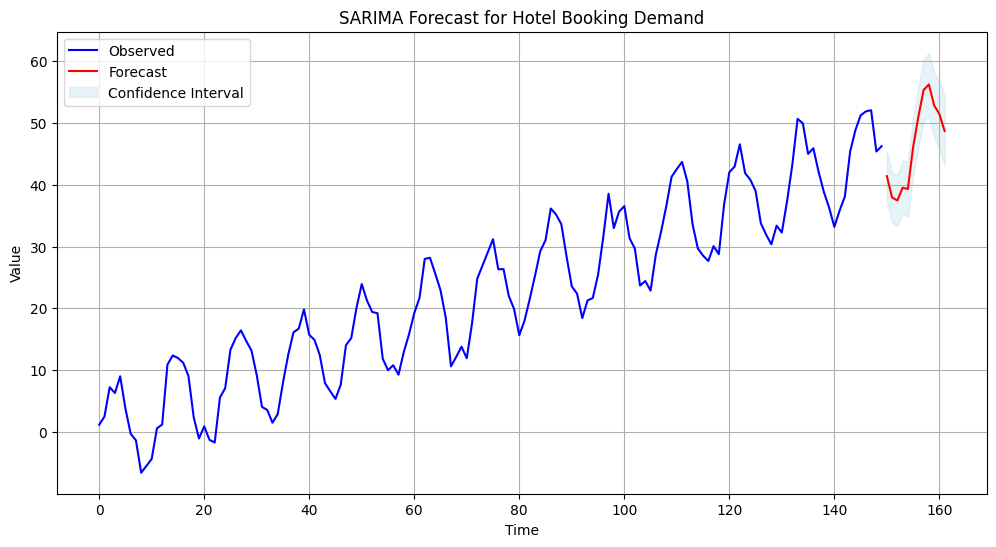

In [138]:
# @title
# Forecast for the next 12 months
n_steps = 12
forecast = results.get_forecast(steps=n_steps)

forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(t_s.index, t_s['Value'], label='Observed', color='blue')

# Forecast line
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')

# Confidence intervals
plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.3, label='Confidence Interval')

plt.title('SARIMA Forecast for Hotel Booking Demand')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

**This chart shows** how the SARIMA(5,1,0) model predicts hotel booking demand for the next 12 months.
- *Blue line — Observed historical data (generated time series).*
It shows a strong upward trend and clear yearly seasonality.
Peaks happen every 12 steps (months).

- *Red line — Forecast predictions for the next 12 months.*
The red curve continues: the upward growth trend; the seasonal shape; the same pattern of ups and downs.

-  *Light blue shaded area — Uncertainty range* - where the future values are expected to fall with 95% probability.

## Forecasting predicts the following:

 1. **Demand will continue to increase**.
The red curve rises higher than the last blue values, so the model predicts continued long-term growth in bookings.
 2. **Seasonality stays stable and predictable**.
The red line forms the same wave like pattern : seasonal highs and lows remain consistent from year to year.
 3. **Forecast uncertainty is low. **
The light blue band is narrow, meaning the model is confident and residuals behaved like white noise.
 4. The forecast follows the exact structure of the generated time series
The SARIMA model captured trend, yearly seasonality and noise.
The predictions look realistic and smooth with no strange jumps.

*To sum up, the SARIMA model forecasts a continued upward trend in hotel booking demand with well-defined seasonal peaks. The uncertainty intervals remain narrow, indicating a stable and reliable model suitable for planning and capacity management.*

**3. OLS Regression for Customer Satisfaction Modelling**